<a href="https://colab.research.google.com/github/TaylorShiehUSI/Github-Colab-test/blob/main/20220814_2230.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
% reset

Once deleted, variables cannot be recovered. Proceed (y/[n])? y


In [2]:
# 下載資料套件
import requests as r

# 資料處理套件
from lxml import etree
import json
from datetime import datetime, date
import pandas as pd

# 財經套件
# import yfinance as yf

# 畫圖套件
import plotly.graph_objects as go

In [3]:
def get_tw_stock_data(start_year, start_month, end_year, end_month, stock_code):
    start_date = str(date(start_year, start_month, 1))
    end_date = str(date(end_year, end_month, 1))
    month_list = pd.date_range(start_date, end_date, freq='MS').strftime("%Y%m%d").tolist()
    
    df = pd.DataFrame()
    for month in month_list:
        url = "https://www.twse.com.tw/exchangeReport/STOCK_DAY?response=json&date="+ month + "&stockNo=" + str(stock_code)
        res = r.get(url)
        stock_json = res.json()
        stock_df = pd.DataFrame.from_dict(stock_json['data'])
        df = df.append(stock_df, ignore_index = True)
        
    # 資料轉型
    for col in [0, 1, 2, 3, 4, 5, 6, 8]:
        for row in range(df.shape[0]):
            # 把"日期"從字串(string)換成時間(datetime)，並將民國年換成西元年
            if col == 0:
                day = df.iloc[row,0].split('/')
                df.iloc[row, 0] = datetime(int(day[0]) + 1911, int(day[1]), int(day[2]))  
            # 把"開盤價", "最高價", "最低價", "收盤價"帶有逗號的字串(string)換成浮點數(float) 
            elif col != 0:
                df.iloc[row, col] = float(df.iloc[row,col].replace(',', ''))
    
    df.columns = ['日期', '成交股數', '成交金額', '開盤價', '最高價', '最低價', '收盤價', '漲跌價差', '成交筆數']
    return df

In [4]:
stock_df = get_tw_stock_data(start_year = 2021, 
                start_month = 1, 
                end_year = 2022, 
                end_month = 8, 
                stock_code = 2330)
stock_df

,日期,成交股數,成交金額,開盤價,最高價,最低價,收盤價,漲跌價差,成交筆數
0,2021-01-04 00:00:00,39489959.0,21127581248.0,530.0,540.0,528.0,536.0,+6.00,33316.0
1,2021-01-05 00:00:00,34839391.0,18761831567.0,536.0,542.0,535.0,542.0,+6.00,28512.0
2,2021-01-06 00:00:00,55614434.0,30572783229.0,555.0,555.0,541.0,549.0,+7.00,55462.0
3,2021-01-07 00:00:00,53392763.0,30018630685.0,554.0,570.0,553.0,565.0,+16.00,47905.0
4,2021-01-08 00:00:00,62957148.0,36339702855.0,580.0,580.0,571.0,580.0,+15.00,56426.0
...,...,...,...,...,...,...,...,...,...
387,2022-08-08 00:00:00,20568971.0,10531710250.0,510.0,515.0,509.0,512.0,-4.00,18131.0
388,2022-08-09 00:00:00,24370709.0,12372442661.0,507.0,511.0,504.0,510.0,-2.00,25433.0
389,2022-08-10 00:00:00,22112239.0,11075581424.0,500.0,503.0,499.5,500.0,-10.00,35188.0
390,2022-08-11 00:00:00,24906177.0,12771121611.0,513.0,514.0,510.0,514.0,+14.00,23949.0


In [5]:
stock_df.to_csv('2230.csv',encoding='utf-8_sig')

In [10]:
## Data Processing // Add is_up
import numpy as np

stock_df['is_up'] = (stock_df['開盤價'].shift(-1) - stock_df['收盤價'] >0).astype('int')
stock_df['高低差'] = (stock_df['最高價'] - stock_df['最低價']).astype('int')
stock_df['漲跌價差'] = (stock_df['收盤價'] - stock_df['開盤價']).astype('int')
stock_df['單筆股數'] = (stock_df['成交股數']/stock_df['成交筆數']).astype('int')

def one_hot(targets, nb_classes):
    return np.eye(nb_classes)[np.array(targets).reshape(-1)]
y_data = one_hot(stock_df['is_up'], 2)
stock_df.head()

,日期,成交股數,成交金額,開盤價,最高價,最低價,收盤價,漲跌價差,成交筆數,is_up,高低差,單筆股數
0,2021-01-04 00:00:00,39489959.0,21127581248.0,530.0,540.0,528.0,536.0,6,33316.0,0,12,1185
1,2021-01-05 00:00:00,34839391.0,18761831567.0,536.0,542.0,535.0,542.0,6,28512.0,1,7,1221
2,2021-01-06 00:00:00,55614434.0,30572783229.0,555.0,555.0,541.0,549.0,-6,55462.0,1,14,1002
3,2021-01-07 00:00:00,53392763.0,30018630685.0,554.0,570.0,553.0,565.0,11,47905.0,1,17,1114
4,2021-01-08 00:00:00,62957148.0,36339702855.0,580.0,580.0,571.0,580.0,0,56426.0,0,9,1115


In [11]:
## Prepare Feature Data
X_data = stock_df.drop(['日期','成交股數','開盤價','最高價','最低價','收盤價','is_up','單筆股數'], axis=1)
X_data.head()
#X_data.columns

,成交金額,漲跌價差,成交筆數,高低差
0,21127581248.0,6,33316.0,12
1,18761831567.0,6,28512.0,7
2,30572783229.0,-6,55462.0,14
3,30018630685.0,11,47905.0,17
4,36339702855.0,0,56426.0,9


In [12]:
## Normalized
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
scaler.fit(X_data)
scaled = scaler.fit_transform(X_data)
X_data = pd.DataFrame(scaled, columns=X_data.columns)
#print(X_data)
X_data.head()

,成交金額,漲跌價差,成交筆數,高低差
0,-0.079254,1.012010,-0.383994,0.611423
1,-0.255043,1.012010,-0.492146,-0.390574
2,0.622583,-0.899835,0.114573,1.012221
3,0.581406,1.808611,-0.055556,1.613419
4,1.051100,0.056087,0.136275,0.010224


In [13]:
## train the model, with preparing the data
from sklearn.model_selection import train_test_split
from keras import backend as K

X_train, X_test, y_train, y_test = train_test_split(X_data, y_data, test_size=0.2)
X_train.shape, X_test.shape, y_train.shape, y_test.shape

X_train = K.cast_to_floatx(X_train)
y_train = K.cast_to_floatx(y_train)
X_test = K.cast_to_floatx(X_test)
y_test = K.cast_to_floatx(y_test)

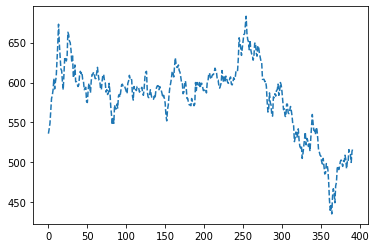

In [14]:
from matplotlib import pyplot as plt
plt.plot( stock_df['收盤價'], '--')
plt.show()


In [15]:
import tensorflow as tf
from tensorflow import keras 
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten


In [16]:
## set up model, and print the model summary
model = Sequential()
model.add(Dense(units = 128,
                input_shape=X_train.shape[1:],
                kernel_initializer = 'normal',
                activation='relu'))
model.add(Dropout(0.25))
model.add(Dense(units = 8,
                kernel_initializer = 'normal',
                activation='relu'))
model.add(Dense(units = 8,
                kernel_initializer = 'normal',
                activation='relu'))
model.add(Dense(units = 2,
                kernel_initializer = 'normal',
                activation='softmax'))
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 128)               640       
                                                                 
 dropout (Dropout)           (None, 128)               0         
                                                                 
 dense_1 (Dense)             (None, 8)                 1032      
                                                                 
 dense_2 (Dense)             (None, 8)                 72        
                                                                 
 dense_3 (Dense)             (None, 2)                 18        
                                                                 
Total params: 1,762
Trainable params: 1,762
Non-trainable params: 0
_________________________________________________________________


In [17]:
## train the model
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy']) 
model.fit(x = X_train,
          y = y_train,
          validation_split = 0.2,
          batch_size=128,
          epochs=600,
          verbose = 2) 

Epoch 1/600
2/2 - 1s - loss: 0.6932 - accuracy: 0.4680 - val_loss: 0.6931 - val_accuracy: 0.4921 - 1s/epoch - 613ms/step
Epoch 2/600
2/2 - 0s - loss: 0.6932 - accuracy: 0.5280 - val_loss: 0.6931 - val_accuracy: 0.5238 - 36ms/epoch - 18ms/step
Epoch 3/600
2/2 - 0s - loss: 0.6931 - accuracy: 0.5200 - val_loss: 0.6931 - val_accuracy: 0.4921 - 33ms/epoch - 16ms/step
Epoch 4/600
2/2 - 0s - loss: 0.6930 - accuracy: 0.5200 - val_loss: 0.6931 - val_accuracy: 0.5079 - 52ms/epoch - 26ms/step
Epoch 5/600
2/2 - 0s - loss: 0.6930 - accuracy: 0.5200 - val_loss: 0.6930 - val_accuracy: 0.5079 - 31ms/epoch - 16ms/step
Epoch 6/600
2/2 - 0s - loss: 0.6929 - accuracy: 0.5200 - val_loss: 0.6930 - val_accuracy: 0.5079 - 38ms/epoch - 19ms/step
Epoch 7/600
2/2 - 0s - loss: 0.6929 - accuracy: 0.5200 - val_loss: 0.6930 - val_accuracy: 0.5079 - 32ms/epoch - 16ms/step
Epoch 8/600
2/2 - 0s - loss: 0.6928 - accuracy: 0.5200 - val_loss: 0.6930 - val_accuracy: 0.5079 - 37ms/epoch - 19ms/step
Epoch 9/600
2/2 - 0s - lo

In [18]:
#myPredict = model.predict_classes( X_test).astype('int64')
myPredict=model.predict(X_test).astype('int64') 
classes_x=np.argmax(myPredict,axis=1)
classes_x

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0])

In [20]:
score = model.evaluate(X_test, y_test, verbose=1)
#print('score', score)

3/3 [==============================] - 0s 4ms/step - loss: 1.0562 - accuracy: 0.4304


In [21]:
y = np.asarray(y_test.nonzero()[1:])
print(myPredict,'\n', y)

[[0 0]
 [0 0]
 [0 0]
 [0 0]
 [0 0]
 [0 0]
 [0 0]
 [0 0]
 [0 0]
 [0 0]
 [0 0]
 [0 0]
 [0 0]
 [0 0]
 [0 0]
 [0 0]
 [0 0]
 [0 0]
 [0 0]
 [0 0]
 [0 0]
 [0 0]
 [0 0]
 [0 0]
 [0 0]
 [0 0]
 [0 0]
 [0 0]
 [0 0]
 [0 0]
 [0 0]
 [0 0]
 [0 0]
 [0 0]
 [0 0]
 [0 0]
 [0 0]
 [0 0]
 [0 0]
 [0 0]
 [0 0]
 [0 0]
 [0 0]
 [0 0]
 [0 0]
 [0 0]
 [0 0]
 [0 0]
 [0 0]
 [0 0]
 [0 0]
 [0 0]
 [0 0]
 [0 0]
 [0 0]
 [0 0]
 [0 0]
 [0 0]
 [0 0]
 [0 0]
 [0 0]
 [0 0]
 [0 0]
 [0 0]
 [0 0]
 [0 0]
 [0 0]
 [0 0]
 [0 0]
 [0 0]
 [0 0]
 [0 0]
 [0 0]
 [0 0]
 [0 0]
 [0 0]
 [0 0]
 [0 0]
 [0 0]] 
 [[1 0 1 1 1 0 1 1 0 0 1 0 0 1 0 0 0 1 0 0 0 0 0 0 0 1 1 1 0 1 0 1 1 0 0 1
  1 0 0 0 0 1 0 1 1 1 0 0 1 0 1 1 1 1 1 1 0 0 1 1 1 1 0 1 0 0 1 1 1 1 0 0
  1 0 1 0 0 1 1]]
